# Multi-Label Classification with MLP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from anime_classification import MultiLabelClassifier, Adam, Trainer

## Load Vectorized Synopsis/Genre Data

In [2]:
synop_vec = pd.read_csv('synopsis_vector.csv')
synop_vec.head()

,MAL_ID,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,1,-0.115479,-3.919922,0.511230,1.325195,2.685547,1.791992,-1.767578,-1.251953,-1.898438,...,0.862305,-0.740234,-1.121094,-0.729004,1.063477,1.272461,-0.246826,1.380859,1.921875,2.216797
1,5,2.314453,-2.361328,-0.012909,2.703125,1.200195,3.173828,-1.356445,-2.605469,-1.958984,...,0.493652,-0.944824,-0.937500,-0.261475,2.087891,1.500000,-0.221802,0.646973,2.218750,0.958496
2,6,-0.226196,-2.597656,-0.182983,2.042969,1.670898,1.951172,-1.367188,-2.917969,-0.160767,...,-1.435547,-1.021484,-2.537109,-2.455078,2.013672,1.943359,0.622559,1.703125,2.357422,1.232422
3,7,0.844238,-0.527344,0.271973,0.752930,1.575195,2.492188,-1.652344,-2.705078,-2.269531,...,-0.367920,-1.791992,-1.804688,-2.474609,2.878906,0.425537,-0.583008,3.107422,0.836426,1.042969
4,8,1.521484,-2.650391,0.424072,1.816406,2.029297,1.694336,0.607910,-1.333984,-1.023438,...,1.650391,-1.703125,-2.476562,-4.492188,1.403320,0.638672,0.058594,1.249023,2.457031,2.517578


In [3]:
genre_vec = pd.read_csv('genre.csv')
genre_vec.head()

,MAL_ID,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,1,1,1,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,5,1,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,6,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,8,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


## Split Train-Test Set

In [4]:
synop_cols = synop_vec.columns.drop('MAL_ID').values
genre_cols = genre_vec.columns.drop('MAL_ID').values

In [5]:
full_vec = pd.merge(synop_vec, genre_vec)
full_vec.head()

,MAL_ID,0,1,2,3,4,5,6,7,8,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,1,-0.115479,-3.919922,0.511230,1.325195,2.685547,1.791992,-1.767578,-1.251953,-1.898438,...,0,0,1,0,0,0,0,0,0,0
1,5,2.314453,-2.361328,-0.012909,2.703125,1.200195,3.173828,-1.356445,-2.605469,-1.958984,...,0,0,1,0,0,0,0,0,0,0
2,6,-0.226196,-2.597656,-0.182983,2.042969,1.670898,1.951172,-1.367188,-2.917969,-0.160767,...,0,0,0,0,0,0,0,0,0,0
3,7,0.844238,-0.527344,0.271973,0.752930,1.575195,2.492188,-1.652344,-2.705078,-2.269531,...,0,0,0,0,0,1,0,0,0,0
4,8,1.521484,-2.650391,0.424072,1.816406,2.029297,1.694336,0.607910,-1.333984,-1.023438,...,0,0,0,0,0,1,0,0,0,0


In [6]:
# random shuffle and re-index
full_vec = full_vec.sample(frac=1).reset_index(drop=True)
full_vec.head()

,MAL_ID,0,1,2,3,4,5,6,7,8,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,152,0.702148,-0.670898,0.275635,2.185547,1.821289,1.121094,-2.980469,-3.541016,-0.506836,...,0,0,0,0,1,0,0,0,0,0
1,3305,-0.408691,-2.222656,0.479248,1.563477,1.099609,1.427734,-1.668945,-0.686035,-1.058594,...,0,0,0,0,0,0,0,0,0,0
2,220,0.250488,-1.990234,0.635742,1.045898,1.049805,0.734375,-0.468750,-2.064453,-2.736328,...,0,0,0,0,0,0,0,0,0,0
3,18897,1.130859,-1.708984,0.299805,1.824219,2.050781,1.876953,-1.552734,-1.493164,-1.374023,...,0,0,0,0,0,0,0,0,0,0
4,10863,1.394531,-0.952148,1.733398,2.230469,0.469482,3.851562,-0.990234,-1.993164,-0.837402,...,0,0,0,0,0,0,1,0,0,0


In [7]:
# split dataframe to train-test numpy array
train_ratio = 0.95
num_train = int(len(full_vec) * train_ratio)

x_train = full_vec[synop_cols][:num_train].values
t_train = full_vec[genre_cols][:num_train].values
id_train = full_vec['MAL_ID'][num_train:].values

x_test = full_vec[synop_cols][num_train:].values
t_test = full_vec[genre_cols][num_train:].values
id_test = full_vec['MAL_ID'][num_train:].values

del synop_vec, genre_vec, full_vec

In [8]:
# standardization
x_train_mean = x_train.mean(axis=0)
x_train_std  = x_train.std(axis=0)

x_train = (x_train - x_train_mean) / x_train_std
x_test  = (x_test  - x_train_mean) / x_train_std

## Define Model

In [9]:
input_size  = len(synop_cols)
output_size = len(genre_cols)

model = MultiLabelClassifier(input_size=input_size,
                             hidden_size_list=[50, 50],
                             output_size=output_size,
                             use_dropout=True,
                             dropout_ratio=0.5,
                             use_batchnorm=True,
                             use_focal_loss=True,
                             focal_gamma=2)
model.summary()

------------------------------------------------------------
Affine(input_size=100, output_size=50, weight_init=he)
------------------------------------------------------------
BatchNormalization(size_layer=50)
------------------------------------------------------------
Relu()
------------------------------------------------------------
Dropout(dropout_ratio=0.5)
------------------------------------------------------------
Affine(input_size=50, output_size=50, weight_init=he)
------------------------------------------------------------
BatchNormalization(size_layer=50)
------------------------------------------------------------
Relu()
------------------------------------------------------------
Dropout(dropout_ratio=0.5)
------------------------------------------------------------
Affine(input_size=50, output_size=43, weight_init=xavier)
------------------------------------------------------------
FocalLoss(gamma=2)
------------------------------------------------------------


In [10]:
optimizer = Adam(lr=0.001)
trainer = Trainer(model, optimizer)

## Train Model

In [11]:
num_epochs = 50
batch_size = 100

trainer.fit(x_train, t_train, x_test, t_test, 
            max_epoch=num_epochs, 
            batch_size=batch_size)

| epoch   1 | time   0[s] | train loss 4.59 | val loss 4.48
| epoch   2 | time   1[s] | train loss 3.89 | val loss 3.74
| epoch   3 | time   1[s] | train loss 3.70 | val loss 3.55
| epoch   4 | time   2[s] | train loss 3.58 | val loss 3.45
| epoch   5 | time   2[s] | train loss 3.51 | val loss 3.40
| epoch   6 | time   3[s] | train loss 3.49 | val loss 3.39
| epoch   7 | time   3[s] | train loss 3.42 | val loss 3.34
| epoch   8 | time   3[s] | train loss 3.42 | val loss 3.36
| epoch   9 | time   4[s] | train loss 3.40 | val loss 3.35
| epoch  10 | time   4[s] | train loss 3.40 | val loss 3.35
| epoch  11 | time   4[s] | train loss 3.38 | val loss 3.36
| epoch  12 | time   5[s] | train loss 3.38 | val loss 3.36
| epoch  13 | time   5[s] | train loss 3.34 | val loss 3.32
| epoch  14 | time   6[s] | train loss 3.31 | val loss 3.30
| epoch  15 | time   6[s] | train loss 3.34 | val loss 3.34
| epoch  16 | time   6[s] | train loss 3.31 | val loss 3.31
| epoch  17 | time   7[s] | train loss 3

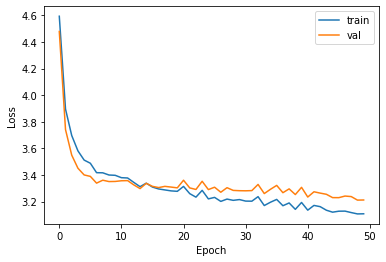

In [12]:
trainer.plot()

In [13]:
def print_prob(probs, labels):
    items = [x for x in sorted(zip(probs, genre_cols), reverse=True)]
    for (prob, genre), label in zip(items, labels):
        print('{:15s}{:>5.2f}% {}'.format(genre, prob*100, label))

In [14]:
num_show = 2
i_start = 0

y_train = model.predict(x_train)

for idx in range(i_start, num_show+i_start):
    print_prob(y_train[idx], t_train[idx])
    print()

Action         47.01% 1
Sci-Fi         43.11% 0
Comedy         38.46% 0
Adventure      36.39% 0
Drama          36.06% 0
Shounen        31.63% 0
Mecha          30.58% 0
Hentai         29.33% 0
Fantasy        29.25% 0
Romance        28.87% 0
Military       26.51% 0
Historical     24.69% 0
Seinen         24.63% 0
Supernatural   23.13% 0
Mystery        23.04% 0
School         21.82% 0
Space          20.24% 0
Super Power    19.52% 0
Slice of Life  19.06% 0
Magic          18.11% 0
Ecchi          18.06% 0
Police         17.47% 0
Kids           17.09% 0
Horror         15.39% 0
Sports         14.20% 0
Psychological  14.17% 0
Shoujo         13.04% 0
Martial Arts   13.03% 0
Music          12.96% 1
Harem          12.37% 0
Demons         11.38% 0
Parody          9.41% 0
Game            8.76% 0
Samurai         8.24% 0
Thriller        6.50% 0
Vampire         6.28% 0
Cars            6.04% 0
Yuri            4.75% 1
Dementia        4.64% 0
Josei           4.39% 0
Shoujo Ai       4.05% 0
Shounen Ai      

In [15]:
num_show = 10
i_start = 0

y_test = model.predict(x_test)

for idx in range(i_start, num_show+i_start):
    # print_prob(y_test[idx], t_test[idx])
    # print()

    mal_id = id_test[idx]
    
    predict = y_test[idx]>=0.5
    actual  = t_test[idx]==1

    TP = (actual & predict).sum()
    FP = (~actual & predict).sum()
    FN = (actual & ~predict).sum()
    TN = (~actual & ~predict).sum()
    
    print('{:^4} {:^4} {:^4} {:^4}'.format('T>T', 'F>T', 'T>F', 'F>F'))
    print('{:^4} {:^4} {:^4} {:^4}\n'.format(TP, FP, FN, TN))


    # print('{:^7} {:^7} {:^7} {:^7} {:^7}'.format('True', 'Pred', 'Correct', 'Wrong', 'Missed'))
    # print('{:^7} {:^7} {:^7} {:^7} {:^7}\n'.format(n_true, n_pred, n_correct, n_wrong, n_missed))

T>T  F>T  T>F  F>F 
 0    1    5    37 

T>T  F>T  T>F  F>F 
 0    0    4    39 

T>T  F>T  T>F  F>F 
 2    2    2    37 

T>T  F>T  T>F  F>F 
 0    0    1    42 

T>T  F>T  T>F  F>F 
 2    1    1    39 

T>T  F>T  T>F  F>F 
 0    0    4    39 

T>T  F>T  T>F  F>F 
 2    1    4    36 

T>T  F>T  T>F  F>F 
 1    1    3    38 

T>T  F>T  T>F  F>F 
 0    0    3    40 

T>T  F>T  T>F  F>F 
 1    1    3    38 

